
DIM2 - Nombre de points utilisés par x commun :
% function evaluation  1.0     2.0     3.0     4.0     5.0     6.0     7.0     \
N                          15      15      15      15      15      15      15   

% function evaluation  8.0     10.0    11.0    ...  1122.0  1258.0  1412.0  \
N                          15      15      15  ...      15      15      15   

% function evaluation  1584.0  1778.0  1995.0  2000.0  2238.0  2511.0  2818.0  
N                          15      15      15      15      15      15      15  

[1 rows x 61 columns]
Figure sauvegardée : ../../figures/figures_abc/figure_f6_abc\f6_abc_tous_les_runs_DIM2.png


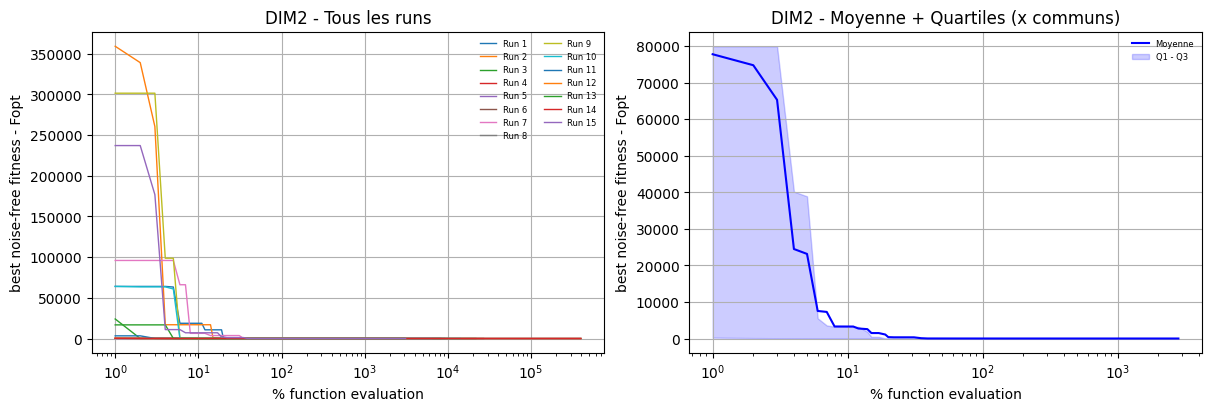


DIM3 - Nombre de points utilisés par x commun :
% function evaluation  1.0      2.0      3.0      4.0      5.0      6.0      \
N                           15       15       15       15       15       15   

% function evaluation  7.0      8.0      10.0     11.0     ...  3548.0   \
N                           15       15       15       15  ...       15   

% function evaluation  3981.0   4466.0   5011.0   5623.0   6309.0   7079.0   \
N                           15       15       15       15       15       15   

% function evaluation  7943.0   8912.0   10000.0  
N                           15       15       15  

[1 rows x 72 columns]
Figure sauvegardée : ../../figures/figures_abc/figure_f6_abc\f6_abc_tous_les_runs_DIM3.png


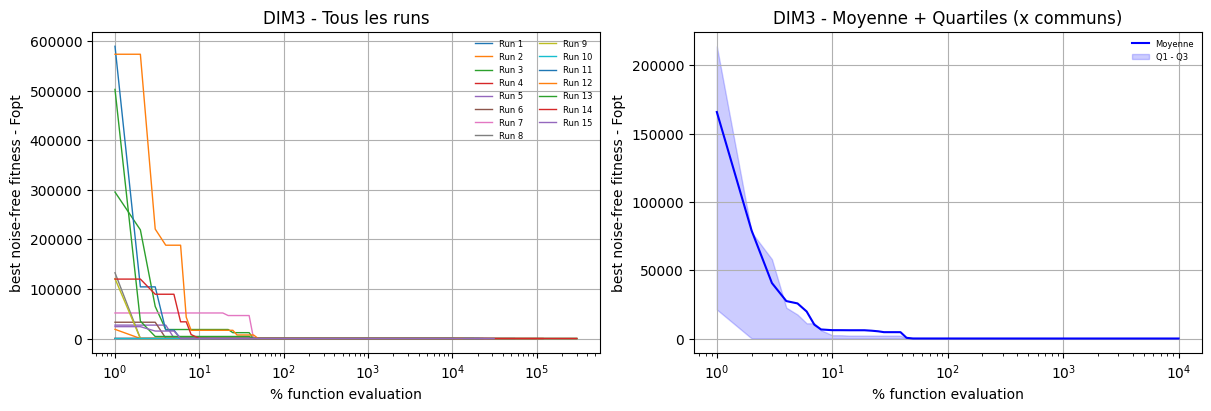


DIM10 - Nombre de points utilisés par x commun :
% function evaluation  1.0       2.0       3.0       4.0       5.0       \
N                            15        15        15        15        15   

% function evaluation  6.0       7.0       8.0       10.0      11.0      ...  \
N                            15        15        15        15        15  ...   

% function evaluation  316227.0  354813.0  398107.0  446683.0  501187.0  \
N                            15        15        15        15        15   

% function evaluation  562341.0  630957.0  707945.0  794328.0  891250.0  
N                            15        15        15        15        15  

[1 rows x 108 columns]
Figure sauvegardée : ../../figures/figures_abc/figure_f6_abc\f6_abc_tous_les_runs_DIM10.png


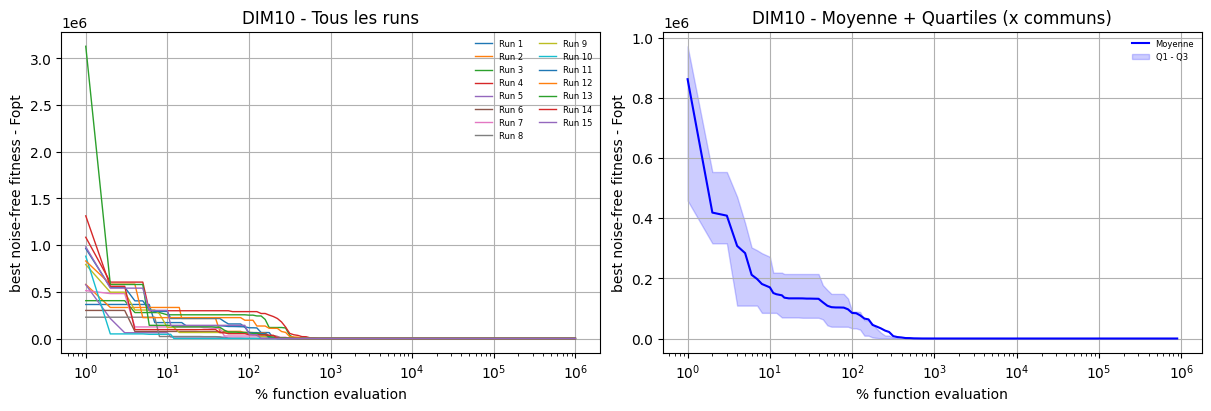

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

files = [
    "../../data/data_abc/data_f6/bbobexp_f6_DIM2.tdat",
    "../../data/data_abc/data_f6/bbobexp_f6_DIM3.tdat",
    "../../data/data_abc/data_f6/bbobexp_f6_DIM10.tdat"
]
def parse_all_runs(file_path):
    all_runs = []
    run_data = []
    inside_run = False
    run_id = 0

    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            if line.startswith('% function evaluation'):
                if run_data:
                    df_run = pd.DataFrame(run_data, columns=[
                        '% function evaluation', 'best noise-free fitness - Fopt'])
                    df_run['run_id'] = run_id
                    all_runs.append(df_run)
                    run_data = []
                    run_id += 1
                inside_run = True
                continue
            if inside_run:
                values = line.split()
                if len(values) > 2:
                    try:
                        x_val = float(values[0])
                        y_val = float(values[2])
                        run_data.append([x_val, y_val])
                    except ValueError:
                        continue

    if run_data:
        df_run = pd.DataFrame(run_data, columns=[
            '% function evaluation', 'best noise-free fitness - Fopt'])
        df_run['run_id'] = run_id
        all_runs.append(df_run)

    return all_runs

for file_path in files:
    runs = parse_all_runs(file_path)

    filename = os.path.basename(file_path)
    match_dim = re.search(r'DIM(\d+)', filename)
    dimension = match_dim.group(1) if match_dim else "?"

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    for i, df_run in enumerate(runs):
        axs[0].plot(df_run['% function evaluation'],
                    df_run['best noise-free fitness - Fopt'],
                    linestyle='-', linewidth=1, label=f'Run {i+1}')
    axs[0].set_xlabel('% function evaluation')
    axs[0].set_ylabel('best noise-free fitness - Fopt')
    axs[0].set_title(f'DIM{dimension} - Tous les runs')
    axs[0].set_xscale('log')
    axs[0].grid(True)
    axs[0].legend(loc='upper right', fontsize=6, ncol=2, frameon=False)

    common_x = set(runs[0]['% function evaluation'])
    for df_run in runs[1:]:
        common_x &= set(df_run['% function evaluation'])

    if not common_x:
        print(f"Aucun x commun à tous les runs pour DIM{dimension}")
        continue

    filtered_runs = [df[df['% function evaluation'].isin(common_x)] for df in runs]
    df_total = pd.concat(filtered_runs, ignore_index=True)

    stats = df_total.groupby('% function evaluation')['best noise-free fitness - Fopt'].describe(
        percentiles=[0.25, 0.5, 0.75]
    ).rename(columns={
        'count': 'N',
        'mean': 'Moyenne',
        '25%': 'Q1',
        '50%': 'Médiane',
        '75%': 'Q3'
    })

    x_vals = stats.index
    axs[1].plot(x_vals, stats['Moyenne'], '-', color='blue', label='Moyenne', markersize=4)
    axs[1].fill_between(x_vals, stats['Q1'], stats['Q3'], alpha=0.2, color='blue', label='Q1 - Q3')
    axs[1].set_xlabel('% function evaluation')
    axs[1].set_ylabel('best noise-free fitness - Fopt')
    axs[1].set_title(f'DIM{dimension} - Moyenne + Quartiles (x communs)')
    axs[1].set_xscale('log')
    axs[1].grid(True)
    axs[1].legend(loc='upper right', fontsize=6, frameon=False)

    print(f"\nDIM{dimension} - Nombre de points utilisés par x commun :")
    print(stats[['N']].astype(int).transpose())

    save_folder = "../../figures/figures_abc/figure_f6_abc"
    os.makedirs(save_folder, exist_ok=True)
    algo = "ABC"
    save_filename = f"f6_abc_tous_les_runs_DIM{dimension}.png"
    save_path = os.path.join(save_folder, save_filename)
    plt.savefig(save_path)
    print(f"Figure sauvegardée : {save_path}")

    plt.show()
